In [1]:
#install required modules
!pip install pillow
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=f6fd4688934aea0fde3b6e555238c45c6a49cd7d8393b20d1247cd88cbdac9e0
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [2]:
#imports
from google.colab import drive
from PIL import Image
import face_recognition
from scipy.spatial import distance
import requests, zipfile, io, gzip
import os
from random import randrange
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle

In [3]:
#mounting google drive. Required to store dataset and intermediate files for model.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#define a function to get distance between features
def distance_between_feature(point1, points2):
  dist = 0.0
  for i in range(0,len(point1)):
    dist = dist+  distance.euclidean(point1[i], points2[i])
  return dist/len(point1);

In [1]:
#We are using euclidean distance to calculate distance between facial features of 2 people.
def find_euclidean_distance(face_features1, face_features2):
  distance = 0.0
  distance_array = []
  for area in face_features1:
    person1 = face_features1[area]
    person2 = face_features2[area]
    
    distance = distance + distance_between_feature(person1,person2);
    distance_array.append(distance);
    
  return distance_array


In [6]:
#download dataset 1
r = requests.get("http://www.kinfacew.com/dataset/KinFaceW-I.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("dataset/")

In [7]:
#download dataset 2
r = requests.get("http://www.kinfacew.com/dataset/KinFaceW-II.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("dataset/")

In [8]:
#generate a csv file for training and testing
CURRENT_DIRECTORY = os.getcwd()
data = open("all-data.csv","w")

data.write("image1,image2,relationship?")
data.write("\n")

1

In [9]:
#define folder names
folders = ["father-dau", "mother-dau", "father-son", "mother-son" ] 

In [10]:
TOTAL_POSITIVE_SAMPLES = 0

In [11]:
FOLDER_BASE_PATH =  "./dataset/KinFaceW-I/images"

In [12]:
'''
How are we generating training data?
There are 2 zip files : KinFaceW-I and KinFaceW-II. These folders contain `images` folder which in turn contains 4 folders.
This folders are : mother-son, mother-daughter, father-son, father-daughter.
In each folder, images ms_001_1 an ms_001_2 are related, ms_002_1 and ms_002_2 are related and so on.
So this is how we know image pairs who are related.

Format of all-data.csv is  image1 image2 relationship? - 3 columns
Where image1 is relative path to image1 and image2 is relative path to second image and relationship is 0 or 1.
'''
data = open("all-data.csv","a")
for folder in folders:
  
  for f in os.listdir(FOLDER_BASE_PATH+"/"+folder):
    if f.endswith('1.jpg'):
      TOTAL_POSITIVE_SAMPLES += 1
      data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+f[:-5]+'2.jpg'+ "," + '1\n')
data.close()

In [13]:
#Generate pairs of positive samples i.e. where genetic relationship exists.
FOLDER_BASE_PATH =  "./dataset/KinFaceW-II/images"
data = open("all-data.csv","a")
for folder in folders:
  
  for f in os.listdir(FOLDER_BASE_PATH+"/"+folder):
    if f.endswith('1.jpg'):
      TOTAL_POSITIVE_SAMPLES += 1
      data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+f[:-5]+'2.jpg'+ "," + '1\n')
data.close()


In [14]:
TOTAL_NEGATIVE_NUMBERS = 0

In [15]:
#now try to generate data with no relationship
NUMBER_OF_PAIRS = 10

FOLDER_BASE_PATH =  "./dataset/KinFaceW-II/images"
data = open("all-data.csv","a")
for folder in folders:
  file_names = os.listdir(FOLDER_BASE_PATH +"/"+folder)
  if 'Thumbs.db' in file_names:
    file_names.remove('Thumbs.db')
  for f in os.listdir(FOLDER_BASE_PATH +"/"+folder):
    if f.endswith('1.jpg'):
      file_names.remove(f[:-5]+'2.jpg')
      for i in range(0, NUMBER_OF_PAIRS):
        TOTAL_NEGATIVE_NUMBERS += 1
        data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+file_names[i] + "," + '0\n')
      file_names.append(f[:-5]+'2.jpg')
    elif f.endswith('2.jpg') :
      #print(f)
      file_names.remove(f[:-5]+'1.jpg')
      for i in range(0, NUMBER_OF_PAIRS):
        TOTAL_NEGATIVE_NUMBERS += 1
        data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+file_names[i] + "," + '0\n')
      file_names.append(f[:-5]+'1.jpg')

data.close()

In [16]:
#now try to generate data with no relationship
FOLDER_BASE_PATH =  "./dataset/KinFaceW-I/images"
data = open("all-data.csv","a")
for folder in folders:
  file_names = os.listdir(FOLDER_BASE_PATH +"/"+folder)
  if 'Thumbs.db' in file_names:
    file_names.remove('Thumbs.db')
  for f in os.listdir(FOLDER_BASE_PATH +"/"+folder):
    if f.endswith('1.jpg'):
      file_names.remove(f[:-5]+'2.jpg')
      for i in range(0, NUMBER_OF_PAIRS):
        TOTAL_NEGATIVE_NUMBERS += 1
        data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+file_names[i] + "," + '0\n')
      file_names.append(f[:-5]+'2.jpg')
    elif f.endswith('2.jpg') :
      #print(f)
      file_names.remove(f[:-5]+'1.jpg')
      for i in range(0, NUMBER_OF_PAIRS):
        TOTAL_NEGATIVE_NUMBERS += 1
        data.write(FOLDER_BASE_PATH+"/"+folder+"/"+f + "," + FOLDER_BASE_PATH+"/"+folder+"/"+file_names[i] + "," + '0\n')
      file_names.append(f[:-5]+'1.jpg')

data.close()

In [17]:
print("Positive samples : ",TOTAL_POSITIVE_SAMPLES)
print("Negative samples : ",TOTAL_NEGATIVE_NUMBERS)

Positive samples :  1533
Negative samples :  30660


In [18]:
flag = 0
count = 0
X = open("X.txt","a")
y = open("y.txt","a")
'''
Open the all-data.csv.
For each sample, read images generate face landmarks and calculate the euclidean distance between face features.
Vector of euclidean difference is X and relationship? is y part of training data.
'''
for entry in open('all-data.csv','r'):
  if flag == 0 :
    flag = 1
    continue
  if flag == 1 :
    flag = 2
    continue
  splitted = entry.split(",")
  image_1 = splitted[0]
  image_2 = splitted[1]
  image_array1 = face_recognition.load_image_file(image_1)
  face_landmarks_list1 = face_recognition.face_landmarks(image_array1)
  image_array2 = face_recognition.load_image_file(image_2)
  face_landmarks_list2 = face_recognition.face_landmarks(image_array2)
  if(len(face_landmarks_list1) != 0 and len(face_landmarks_list2) != 0):
    X.write(''.join(str(e)+',' for e in find_euclidean_distance(face_landmarks_list1[0], face_landmarks_list2[0]))+"\n")
    y.write(splitted[2])

In [19]:
X = []
y = []

#load data of euclidean difference vectors from file to list.
for line in open('X.txt','r'):
  line = line[:-2]
  X.append([float(i) for i in line.split(",")])

for line in open('y.txt','r'):
  y.append(int(line[0]))



In [20]:
len(X)

25625

In [21]:
len(y)

25625

In [22]:
y.count(0)

24435

In [23]:
y.count(1)

1190

In [24]:
'''
We faced problem of overfitting due to lot of negative samples.
Hence we try to take out similar number of positive and negative samples.
'''
X_new = [X[i] for i in range(len(X)) if y[i] == 1]
y_new = [1 for i in range(len(X_new))]

In [25]:
'''
When negative samples were 1.5 times the positive samples, we could find good accuracy model.
'''
ONES = (y.count(1) * 3) // 2;
print(ONES)
cnt = 0;
while cnt < ONES:
  index = randrange(len(y))
  if(y[index] == 0):
    y_new.append(0)
    X_new.append(X[index])
    cnt = cnt + 1
    

print(cnt)
y_new.count(0)


1785
1785


1785

In [26]:
#shuffle/randomize data
temp = list(zip(X_new, y_new))
random.shuffle(temp)
X_new, y_new = zip(*temp)

In [27]:
#split the data into parts : train and test
x_train, x_test, y_train, y_test = train_test_split(X_new, y_new,test_size = 0.3)

In [28]:
#We used MultiLayer Perceptron to fit the training data.
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(9,4,7), random_state=1,max_iter=10000,learning_rate='adaptive')
clf.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(9, 4, 7),
              learning_rate='adaptive', max_iter=10000, random_state=1,
              solver='lbfgs')

In [29]:
#print accuracy for testing data.
accuracy_score(clf.predict(x_test), y_test)

0.5991041433370661

In [30]:
test_size = []
accuracy = []
for i in range (1,90):
  test_size.append(i/100)
  x_train, x_test, y_train, y_test = train_test_split(X_new, y_new,test_size = i/100)
  clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5,5), random_state=1,max_iter=10000,learning_rate='adaptive')
  clf.fit(x_train, y_train)
  accuracy.append(accuracy_score(clf.predict(x_test), y_test))



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


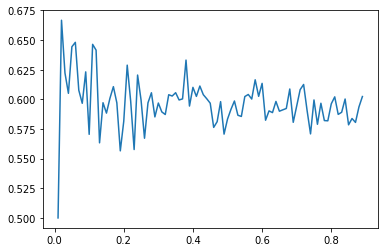

In [31]:
#plot the graph of test size versus accuracy
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(test_size, accuracy)
plt.show()

In [32]:
I = []
J = []
accuracy = []
for i in range (5,10): # 5, 15 and 5, 25
  for j in range (5,10):
    I.append(i)
    J.append(j)
    x_train, x_test, y_train, y_test = train_test_split(X_new, y_new,test_size = 0.20)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i,j), random_state=1,max_iter=10000,learning_rate='adaptive')
    clf.fit(x_train, y_train)
    accuracy.append(accuracy_score(clf.predict(x_test), y_test))

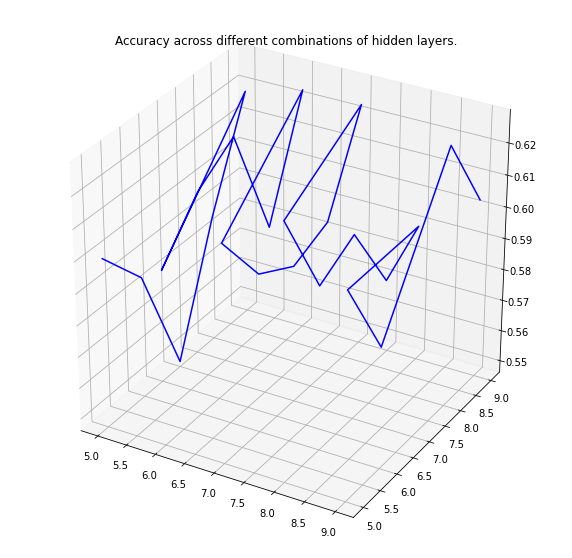

In [33]:
#plot the graph of test size versus accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(I, J, accuracy, 'blue')
ax.set_title('Accuracy across different combinations of hidden layers.')
pickle.dump(ax, open("plot.pickle", "wb"))
plt.show()

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)